# Conditional Generative Advarsarial Network 

Here is presented the following parper https://arxiv.org/abs/1411.1784

This work is similar to the previous one but now the G(z) is replaced with G(z|y) and D(x) by D(x|y). 
Since we only need to modify the Generator and Discriminator network the previous code dont change to much (loss, otimization)

Implementation is done in tensorflow using layers API

Created by: Tiago Almeida 02/02/2018

In [1]:
##imports
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import utils as ut # auxiliar file to help in data visualization

#tensorflow version when notebook was created - 1.4.0
tf.__version__


'1.4.0'

### Data MNIST

Extracting ./data\train-images-idx3-ubyte.gz
Extracting ./data\train-labels-idx1-ubyte.gz
Extracting ./data\t10k-images-idx3-ubyte.gz
Extracting ./data\t10k-labels-idx1-ubyte.gz


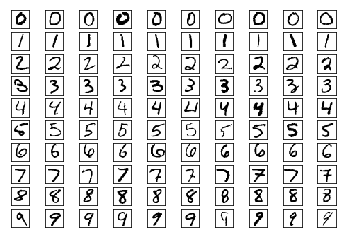

In [2]:
mnist_flat_size = 784

#mnist data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("./data")

#ut.plot_mnist_images(mnist.test.images[0:9])

#reset graph using during notebook development
#tf.reset_default_graph()
images_per_class = 10
images = np.zeros((10*images_per_class,mnist_flat_size))
for l in range(10):
    images[(l*images_per_class):(l*images_per_class+images_per_class)] = mnist.test.images[(mnist.test.labels==l)][:images_per_class]
    
ut.plot_mnist_images_conditonal(images,per_class = images_per_class)


### Generator network 

Same as previous network, only diference is that input Z is concatenated with y

In [3]:
#array that contain the network dimention at least 3 dimention (input, hidden and output dimentions)
z_dimention = 100

G_dimentions = [z_dimention,128,mnist_flat_size]

Z = tf.placeholder(tf.float32, shape=[None, G_dimentions[0]], name='x_generator_input')
Y = tf.placeholder(tf.float32, shape=[None, 10], name='number_label')

def generator(x,y):
    '''
    Generator implemented as MLP
    
    :param x: tensor with shape (M,100) here M = number of samples
    :param y: tensor with shape (M,10) labels in one hot encoder
    :return: tensor with shape (M,784) corresponding to the image (28x28) mapping between x and data distribution (pData)
    '''
    with tf.name_scope("generator_nn"):
        concat_input = tf.concat([x, y], 1)
        
        g_net = tf.layers.dense(concat_input,G_dimentions[1],
                                    activation=tf.nn.relu,
                                    name='g_hidden1',reuse=tf.AUTO_REUSE)
        for i in range(2,len(G_dimentions)-1):#loop throw hidden layers
            g_net = tf.layers.dense(g_net,G_dimentions[i],
                                    activation=tf.nn.relu,
                                    name='g_hidden'+str(i),reuse=tf.AUTO_REUSE)
        g_net = tf.layers.dense(g_net,G_dimentions[-1],activation=tf.nn.sigmoid,name='g_output',reuse=tf.AUTO_REUSE)
        return g_net


### Discriminator network 

Same as previous network, only diference is that input Z is concatenated with y

In [4]:
#array that contain the network dimention at least 3 dimention (input and output dimentions)
D_dimentions = [mnist_flat_size,128,1] ##ouput fake, true

X = tf.placeholder(tf.float32, shape=[None, D_dimentions[0]], name='x_discriminator_input')

def discriminator(x,y):
    '''
    Discriminator implemented as MLP
    
    :param x: tensor with shape (M,784) here M = number of samples
    :param y: tensor with shape (10,1) labels in one hot encoder
    :return: tensor with shape (M,1) corresponding to the probability of each sample being true or fake
    '''
    with tf.name_scope("discriminator_nn"):
        concat_input = tf.concat([x, y], 1)
        
        d_net = tf.layers.dense(concat_input,D_dimentions[1],
                                    activation=tf.nn.relu,
                                    name='d_hidden1',reuse=tf.AUTO_REUSE)
        for i in range(2,len(D_dimentions)-1):#loop throw hidden layers
            d_net = tf.layers.dense(d_net,D_dimentions[i],
                                    activation=tf.nn.relu,
                                    name='d_hidden'+str(i),reuse=tf.AUTO_REUSE)
        d_net = tf.layers.dense(d_net,D_dimentions[-1],activation=None,name='d_output',reuse=tf.AUTO_REUSE)
        #save the logits before the sigmoid activation (ouput between[0,1]) for alternative loss function
        d_logits = d_net
        d_net = tf.nn.sigmoid(d_net)
        return d_net,d_logits

### Loss functions Generator and Discriminator

Same as previous one

In [5]:

#this alternative loss use cross entropy (explanation why this makes senses TODO)
alternative_loss = True

with tf.name_scope("generator_loss"): 
    generated_sample = generator(Z,Y)
    d_fake_prob, d_fake_logits = discriminator(generated_sample,Y) #D(G(Z|Y)|Y)
    
    if alternative_loss:
        g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=tf.ones_like(d_fake_logits)))
    else:
        g_loss = -tf.reduce_mean(tf.log(d_fake_prob))

with tf.name_scope("discriminator_loss"):
    d_true_prob, d_true_logits = discriminator(X,Y)
    if alternative_loss:
        d_loss_true = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_true_logits, labels=tf.ones_like(d_true_logits)))
        d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=tf.zeros_like(d_fake_logits)))
        d_loss = d_loss_fake + d_loss_true
    else:
        d_loss = -tf.reduce_mean(tf.log(d_true_prob) + tf.log(1. - d_fake_prob))

#### Geting the trainable variables for generator and the discriminator (disadvantage of using layers API)

In [6]:
generator_variables = [var for var in tf.trainable_variables() if 'g_' in var.name]
discriminator_variables = [var for var in tf.trainable_variables() if 'd_' in var.name]

# kernel = weight
print(generator_variables)
print(discriminator_variables)

[<tf.Variable 'g_hidden1/kernel:0' shape=(110, 128) dtype=float32_ref>, <tf.Variable 'g_hidden1/bias:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'g_output/kernel:0' shape=(128, 784) dtype=float32_ref>, <tf.Variable 'g_output/bias:0' shape=(784,) dtype=float32_ref>]
[<tf.Variable 'd_hidden1/kernel:0' shape=(794, 128) dtype=float32_ref>, <tf.Variable 'd_hidden1/bias:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'd_output/kernel:0' shape=(128, 1) dtype=float32_ref>, <tf.Variable 'd_output/bias:0' shape=(1,) dtype=float32_ref>]


### Training Algorithm

In [7]:
lr=0.001
with tf.name_scope("discriminator_train"):
    d_optimizer = tf.train.AdamOptimizer(learning_rate=lr)
    d_train_op = d_optimizer.minimize(d_loss, var_list=discriminator_variables) # note minimizing negative loss is the same as maximizing, tf dont have maximizing

with tf.name_scope("generator_train"):
    g_optimizer = tf.train.AdamOptimizer(learning_rate=lr)
    g_train_op = g_optimizer.minimize(g_loss,var_list=generator_variables)


def random_Z(m, n=z_dimention):
    '''
    Random values for Z between -1 and 1
    
    :param m: number of samples
    :param n: dimension of Z
    :return: Vector with shape (m,n)
    '''
    return np.random.uniform(-1., 1., size=[m, n])

def random_y(m):
    '''
    Random labels y in one hot encoding
    
    :param m: number of samples
    :param n: dimension of Z
    :return: Vector with shape (m,n)
    '''
    return one_hot(np.random.randint(10,size=[m,1]))


def one_hot(label):
    '''
    Apply one hot encoding to the label
    
    :param label: Vector with shape (Mx1)
    :return: Matrix with shape (Mx10)
    '''
    print(len(label))
    m = np.zeros((len(label),10))
    m[np.arange(len(label)), label] = 1
    return m
    
## Start graph computations and algorithm


batch_size = 64
epoach = 10000

sess = tf.Session()
sess.run(tf.global_variables_initializer())

for i in range(epoach):
    x_train,y_train = mnist.train.next_batch(batch_size)
    
    y_one_hot = one_hot(y_train)
    print(y_one_hot)
    #first discriminator
    _, d_loss_value = sess.run([d_train_op, d_loss], feed_dict={X: x_train,Y:y_one_hot , Z: random_Z(batch_size)})
    #second generator
    _, g_loss_value = sess.run([g_train_op, g_loss], feed_dict={Z: random_Z(batch_size),Y:random_y(batch_size)})

    if i%100 == 0:
        print("Epoach",i)
        print("Discriminator loss: ",d_loss_value)
        print("Generator loss:",g_loss_value)
        #print("D_sample",d_sample)
        #print("G_sample",g_sample)
        
        #visual progress of training
        z_new = random_Z(images_per_class*10)
        conditional_y = one_hot([[i]*images_per_class for i in range(10)])
        
        generated_images = generated_sample.eval(session=sess,feed_dict={Z: z_new,Y:conditional_y})
        ut.plot_mnist_images_conditonal(generated_images,per_class = images_per_class)


64
[[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0

InternalError: Blas GEMM launch failed : a.shape=(64, 110), b.shape=(110, 128), m=64, n=128, k=110
	 [[Node: generator_loss/generator_nn/g_hidden1/MatMul = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](generator_loss/generator_nn/concat, g_hidden1/kernel/read)]]
	 [[Node: discriminator_loss/add/_19 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_474_discriminator_loss/add", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'generator_loss/generator_nn/g_hidden1/MatMul', defined at:
  File "C:\Users\ASUS\Anaconda3\envs\tf-gpu\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\ASUS\Anaconda3\envs\tf-gpu\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\ASUS\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\ASUS\Anaconda3\envs\tf-gpu\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\ASUS\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "C:\Users\ASUS\Anaconda3\envs\tf-gpu\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\Users\ASUS\Anaconda3\envs\tf-gpu\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "C:\Users\ASUS\Anaconda3\envs\tf-gpu\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\ASUS\Anaconda3\envs\tf-gpu\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Users\ASUS\Anaconda3\envs\tf-gpu\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\ASUS\Anaconda3\envs\tf-gpu\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\ASUS\Anaconda3\envs\tf-gpu\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\ASUS\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\ASUS\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\ASUS\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\ASUS\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\ASUS\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\ASUS\Anaconda3\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\ASUS\Anaconda3\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\ASUS\Anaconda3\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-5-c39b7dbe4b94>", line 6, in <module>
    generated_sample = generator(Z,Y)
  File "<ipython-input-3-bb511a00a11c>", line 22, in generator
    name='g_hidden1',reuse=tf.AUTO_REUSE)
  File "C:\Users\ASUS\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\layers\core.py", line 250, in dense
    return layer.apply(inputs)
  File "C:\Users\ASUS\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\layers\base.py", line 671, in apply
    return self.__call__(inputs, *args, **kwargs)
  File "C:\Users\ASUS\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\layers\base.py", line 575, in __call__
    outputs = self.call(inputs, *args, **kwargs)
  File "C:\Users\ASUS\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\layers\core.py", line 162, in call
    outputs = standard_ops.matmul(inputs, self.kernel)
  File "C:\Users\ASUS\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\ops\math_ops.py", line 1891, in matmul
    a, b, transpose_a=transpose_a, transpose_b=transpose_b, name=name)
  File "C:\Users\ASUS\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\ops\gen_math_ops.py", line 2436, in _mat_mul
    name=name)
  File "C:\Users\ASUS\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\ASUS\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\framework\ops.py", line 2956, in create_op
    op_def=op_def)
  File "C:\Users\ASUS\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\framework\ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InternalError (see above for traceback): Blas GEMM launch failed : a.shape=(64, 110), b.shape=(110, 128), m=64, n=128, k=110
	 [[Node: generator_loss/generator_nn/g_hidden1/MatMul = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](generator_loss/generator_nn/concat, g_hidden1/kernel/read)]]
	 [[Node: discriminator_loss/add/_19 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_474_discriminator_loss/add", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
